<a href="https://colab.research.google.com/github/BaichooSiddharth/Devoir_1_Data_Science/blob/master/Devoir_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [54]:
#Installation
!pip install scikit-learn-extra

#Librairies
import numpy as np
import pandas as pd
import scipy.stats

#Visualization
import matplotlib.pyplot as plt

#Clusters
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances
from sklearn.preprocessing import scale

#les couleurs pour pouvoir plot les points
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [55]:
#on lit et on stock les valeurs qu'une fois dans cette cellule car putain sa mère c'est chiant de reload ça à chaque fois
train_MNIST = np.genfromtxt('mnist_train.csv', delimiter=',')
test_MNIST = np.genfromtxt('mnist_test.csv', delimiter=',')

In [56]:
#On enlève la première rangée qui décrit chaque colonne. On a les labels qui sont à gauche du jeu de données (1ère colonne) et les valeurs sont toutes les colonnes après autour
train_MNIST_relevant = train_MNIST[1:, :]
test_MNIST_relevant = test_MNIST[1:, :]

train_MNIST_relevant_points = train_MNIST_relevant[:, 1:]
train_MNIST_relevant_labels = train_MNIST_relevant[:, 0]

print(train_MNIST_relevant_points[:5])


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [57]:
def groupByClassMNIST(dataset):
    #on regroupe tous les points d'une classe en utilisant cette fonction en des dictionaires
    labels = dataset[:, 0]
    labels_unique = np.unique(labels)
    dictio = dict()
    for label in  labels_unique:
        points = dataset[np.where(dataset[:,0] == label)]
        dictio[label] = points
    return dictio

# **K-médoides**

#Source Scikit-Learn

In [58]:
data = scale(train_MNIST_relevant_points[:1000])
reduced_data = PCA(n_components=2).fit_transform(data)
n_digits = len(np.unique(train_MNIST_relevant_labels))

# Taille du maillage. Diminution pour augmenter la qualité dU graphique.
h = 0.02  # point dans la maille [x_min, m_max]*[y_min, y_max].

# On trace la limite de la décision. Pour cela, nous allons attribuer une couleur à chaque
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

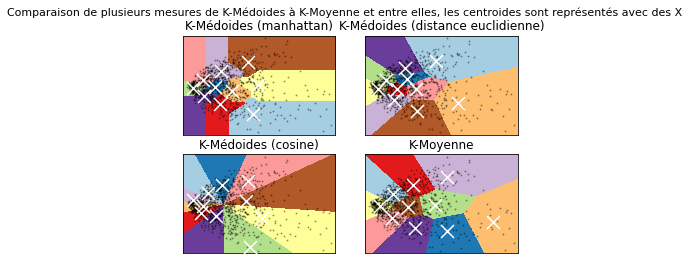

In [59]:
plt.figure()
plt.clf()

plt.suptitle(
    "Comparaison de plusieurs mesures de K-Médoides à K-Moyenne et entre elles, les centroides sont représentés avec des X",
    fontsize=11,
)


selected_models = [
    (
        KMedoids(metric="manhattan", n_clusters=n_digits),
        "K-Médoides (manhattan)",
    ),
    (
        KMedoids(metric="euclidean", n_clusters=n_digits),
        "K-Médoides (distance euclidienne)",
    ),
    (KMedoids(metric="cosine", n_clusters=n_digits), "K-Médoides (cosine)"),
    
    (KMeans(n_clusters=n_digits), "K-Moyenne"),
]

plot_rows = int(np.ceil(len(selected_models) / 2.0))
plot_cols = 2

for i, (model, description) in enumerate(selected_models):

    # On obtient des étiquettes pour chaque point de la maille. Utiliser le dernier modèle formé.
    model.fit(reduced_data)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # On met le résultat dans un graphique en couleur
    Z = Z.reshape(xx.shape)
    plt.subplot(plot_cols, plot_rows, i + 1)
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(
        reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2, alpha=0.3
    )
    # On trace les centroïdes comme un X blanc
    centroids = model.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(description)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

plt.show()

# **Partition binaire**


#Source: https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering

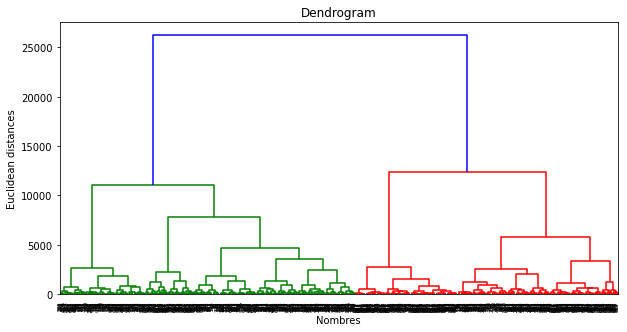

In [62]:
'''
Méthode Ward (ne marche qu'avec la distance euclidienne)
La proximité entre deux clusters est la grandeur par laquelle le carré additionné de leur cluster commune sera plus grand 
que la somme des carrés combinés de ces deux groupes : SS12-(SS1+SS2). (Entre deux objets simples 
cette quantité = distance euclidienne au carré / 2.)
'''

model_eucli = AgglomerativeClustering(n_clusters=10,linkage="ward", affinity='euclidean')
model_eucli = model_eucli.fit(data)

model_eucli.n_clusters_

Z = hierarchy.linkage(model_eucli.children_, 'ward')
plt.figure(figsize=(10,5))
plt.title('Dendrogram')
plt.xlabel('Nombres')
plt.ylabel('Euclidean distances')

dn = hierarchy.dendrogram(Z)


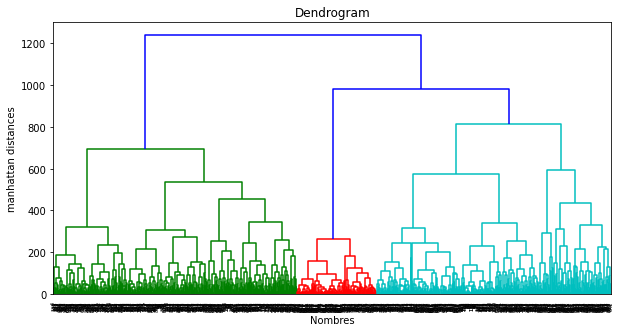

In [63]:
'''
Proximity between two clusters is the arithmetic mean of all the proximities between the objects of one, 
on one side, and the objects of the other, on the other side; while the subclusters of 
which each of these two clusters were merged recently have equalized influence on that 
proximity – even if the subclusters differed in the number of objects.
'''
model_manh = AgglomerativeClustering(n_clusters=10,linkage="average", affinity='manhattan')
model_manh = model_manh.fit(data)

model_manh.n_clusters_

Z = hierarchy.linkage(model_manh.children_, 'average')
plt.figure(figsize=(10,5))
plt.title('Dendrogram')
plt.xlabel('Nombres')
plt.ylabel('manhattan distances')

dn = hierarchy.dendrogram(Z)

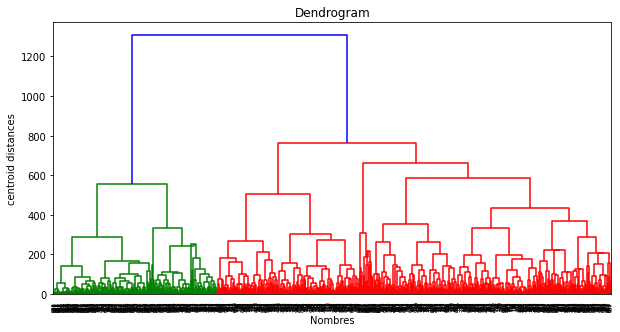

In [64]:
'''
Proximity between two clusters is the arithmetic mean of all the proximities between the objects of one, 
on one side, and the objects of the other, on the other side; while the subclusters of which 
each of these two clusters were merged recently have equalized influence on that proximity – 
even if the subclusters differed in the number of objects.
'''
model_cos = AgglomerativeClustering(n_clusters=10,linkage="average", affinity='cosine')
model_cos = model_cos.fit(data)

model_cos.n_clusters_

Z = hierarchy.linkage(model_cos.children_, 'centroid')
plt.figure(figsize=(10,5))
plt.title('Dendrogram')
plt.xlabel('Nombres')
plt.ylabel('centroid distances')

dn = hierarchy.dendrogram(Z)

# **PCoA**

In [ ]:
class PCoA:
    def __init__(self, similarity, n_components, n_init, max_iterations):
        self.similarity = similarity
        self.n_components = n_components
        self.n_init = n_init
        self.max_iterations = max_iterations
        self.classifier = manifold.MDS(n_components = self.n_components, n_init = self.n_init, max_iter = self.max_iterations, dissimilarity = "precomputed")
        
    def partition(self, x_train, y_train):
        if(self.similarity == 'cosine'):
            similarity_matrix = cosine_similarity(x_train)
            dissimilarity_matrix = 1 - similarity_matrix 
#on prend 1- la similarité car PCoA ne prend que les dissimilarités Sinon ce serait PCA ce qui n'est pas demandé dans la question. Aussi cela fait du sens 
#car la dissimilarité est inversement proportionelle à la similarité et la valeur varie de 0 à 1 donc on prend 1-la solution obtenue)           
        elif(self.similarity == 'euclidean'):
            dissimilarity_matrix = euclidean_distances(x_train)
        
        else:
            dissimilarity_matrix = manhattan_distances(x_train)
        nouveaux_points = self.classifier.fit_transform(dissimilarity_matrix)
        num_points = y_train.shape[0]
        final_array = np.zeros((num_points,(self.n_components + 1)))
        final_array[:, 1:] = nouveaux_points
        final_array[:, 0] = y_train
        return final_array
        

def plot_points_MNIST(dict_new_points):
    for i,j in enumerate(dict_new_points):
        spec_class = dict_new_points[j]
        x_axis = spec_class[:, 1]
        y_axis = spec_class[:, 2]
        plt.plot(x_axis, y_axis, colors[i], marker = 'o', linestyle = 'None', label = j)
        
    plt.legend(loc='best')   
    plt.show
    
        

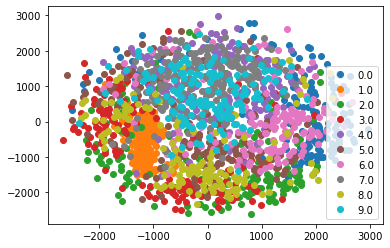

In [ ]:
pcoa_euclidean = PCoA('euclidean', 2, 4, 1600)

projected_points_euclidean = pcoa_euclidean.partition(train_MNIST_relevant_points[0:1500], train_MNIST_relevant_labels[0:1500])

pcoa_grouped_points_euclidean = groupByClassMNIST(projected_points_euclidean)

plot_points_MNIST(pcoa_grouped_points_euclidean)


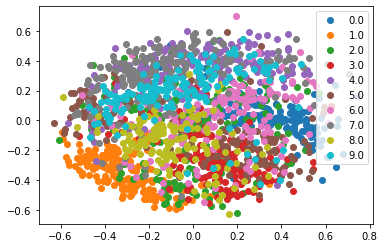

In [ ]:
pcoa_cosine = PCoA('cosine', 2, 4, 1600)

projected_points_cosine = pcoa_cosine.partition(train_MNIST_relevant_points[0:1500], train_MNIST_relevant_labels[0:1500])

pcoa_grouped_points_cosine = groupByClassMNIST(projected_points_cosine)

plot_points_MNIST(pcoa_grouped_points_cosine)



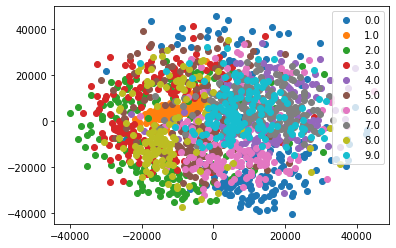

In [ ]:
pcoa_manhattan = PCoA('manhattan', 2, 4, 1600)

projected_points_manhattan = pcoa_manhattan.partition(train_MNIST_relevant_points[0:1500], train_MNIST_relevant_labels[0:1500])

pcoa_grouped_points_manhattan = groupByClassMNIST(projected_points_manhattan)

plot_points_MNIST(pcoa_grouped_points_manhattan)

In [ ]:
#fonction qui calcule un ratio pour connaître le regroupement relatif des points
#on a un dictionnaire avec les clefs étant les classes de mnist et les valeurs étant les points avec le label en 1ère colonne et les positions en n dimensiosn des points
#On calcule la distance de la moyenne d'une classe à la moyenne des autres classes et on la divise par la distance du premier point de cette classe à la moyenne de cette classe
#Puis on fait le ratio de la distance des moyennes de chaque classe sur la distance du premier point de la moyenne d'une classe spécifique
#On éxécute les instructions en haut puis on fait les moyennes des ratios obtenus pour chaque classe
def get_ratios(dict_values):
    distance_dict = dict()
    for i in dict_values:
        li = []
        spec_class = dict_values[i]
        data_points = spec_class[:, 1:]
        mean_spec = np.mean(data_points)
        point = data_points[0]
        distance_first_point = np.linalg.norm(point-mean_spec)
        for j in dict_values:
            if(i == j):
                ratio = 0
            else:
                o_spec_class = dict_values[j]
                points = o_spec_class[:, 1:]
                mean_o_spec = np.mean(points)
                distance = np.linalg.norm(mean_spec-mean_o_spec)
                ratio = distance/distance_first_point
            
            li.append(ratio)
        #on retourne la moyenne des ratios    
        distance_dict[i] = np.mean(li)
        
    return distance_dict

def plot_ratios(dict_values):
    x_axis = dict_values.keys()
    for ind,elem  in enumerate(x_axis):
        plt.plot(elem, dict_values[elem], colors[ind], marker = 'o', linestyle = 'None', label = elem)
        
    plt.legend(loc='best')   
    plt.show
        


ratio manhattan


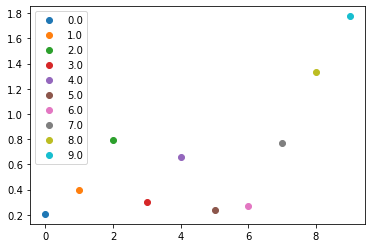

In [ ]:
ratio_dict_manhattan = get_ratios(pcoa_grouped_points_manhattan)
ratio_dict_euclidean = get_ratios(pcoa_grouped_points_euclidean)
ratio_dict_cosine = get_ratios(pcoa_grouped_points_cosine)
grouped_points_original = groupByClassMNIST(train_MNIST_relevant[0:1500])
ratio_dict_original = get_ratios(grouped_points_original)

print("ratio manhattan")
plot_ratios(ratio_dict_manhattan)


ratio_euclidean


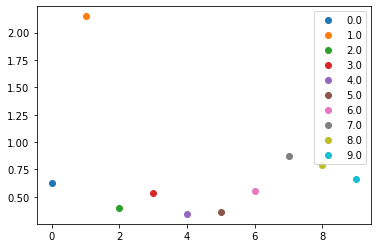

In [ ]:
print("ratio_euclidean")
plot_ratios(ratio_dict_euclidean)


ratio_cosine


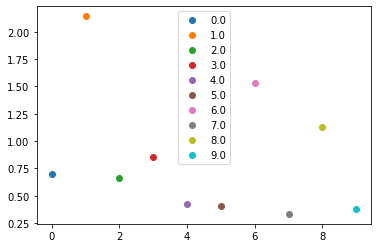

In [ ]:
print("ratio_cosine")
plot_ratios(ratio_dict_cosine)


ratio_original


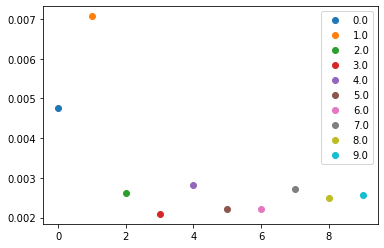

In [ ]:
print("ratio_original")
plot_ratios(ratio_dict_original)

L'algorithme qui a les mieux séparé les points était le PCoA avec la distance cosinus (1- similarité_cosinus) avec les points de la classe 1 les mieux séparés suivis de ceux de la classe 6. 
Puis le PCoA avec la distance euclidienne a séparé les points de la classe 1 les mieux (comme avec la distance cosinus) suivi des points de la classe 7.
Puis celle utilisant la distance manhattan a séparé les points de la classe 9 le mieux suivi des points de la classe 8.

Les 3 résultats obtenus sont meilleurs que les points originaux car le ratio est une mesure de la séparation approximative d'une classe des autres. Le ratio est bien meilleur que l'original où la valeur maximale ne dépassait pas 0.007 (pour la classe 1). Maintenant on a un ratio maximal d'environ 2.2 pour les PCoA avec une la distance euclidienne et la distance cosinus. Aussi la distance cosinus a fait mieux que la distance euclidienne en moyenne. Puis en dernier (parmi les points partitionés) on a la distance manhattan qui a un ratio maximal d'environ 1.8.  

# **Isomap**

# **KNN**